# Recurrent neural networks

## Motivation

Up to now we used neural networks to learn functions that predicted a desired output $y$ based on an input vector $x$. We have assumed that $x$ has a constant size, such as an image of a given resolution.

In contrast, recurrent networks can be applied to sequences of different length.

Consider the problem of computing the parity checksum of a sequence of bits. Traditional neural networks that we know can not be applied to bit sequences of arbitrary length, yet a program which reads in the sequence bit-by-bit is very easy to write. 

Another motivating example is sequence generation, such as generating text or music. Again, normal neural networks that take a fixed input size are not directly applicable to whole sequences.

## Autoregressive models

An autoregressive model assumes, that the $i$-th element of a sequence depends only on a few preceding sequence elements. Lets first write the exact probability of observing a sequence $\mathbf{Y} = [Y_1, Y_2, \ldots, Y_m]$:

$$
    P(\mathbf{Y}) = P(Y_1)P(Y_2|Y_1)P(Y_3|Y_1, Y_2)\ldots P(Y_m|Y1,Y_2,\ldots,Y_{n-1})=\prod_i P(Y_i|Y_1,\ldots, Y_{i-1})
$$

The autoregressive model simply assumes that we can use only a finite history, that is:
$$
    P(Y_i|Y_1,\ldots, Y_{i-1}) \approx P(Y_i|Y_{i-n},\ldots, Y_{i-1})
$$

Autoregressive models are quite frequently used, because they are easy to implement - it is sufficient extract $n$ element long subsequences and learn a model that predicts the last element given the $n-1$ preceding ones. Thus autoregressive models reduce the sequence learning problem to the typicall supervised learning setup

### Examples

Autoregressive models are very popular, for instance:

1. Language models (that is models which tell how probable is a given utterance) are often expressed as $n$-gram models in which $P(Y_i|Y_{i-n},\ldots, Y_{i-1})$ is simply established by counting occurrences in a corpus of text.
2. The ARMA model used in timeseries prediction is expressed as:
    $$
        Y_t = \sum_{i=1}^{n}\alpha_i Y_{t-i} + \sum_{i=1}^k \Theta_i \epsilon_{t-i},
    $$
    where $\epsilon_i$ are assumed to be normally distributed noise variables.
    
## Models with a hidden state

Autoregressive models have a very short memory which limits their applicability. We can build a more powerfull model by introducing a sequence of hidden states $\mathbf{H} = [H_0, H_1, \ldots]$. We will assume that all history of a sequence can be captured by the state:

$$
    P(Y_i|Y_1,\ldots, Y_{i-1}) \approx P(Y_i|Y_{i-n}, H_{i-1})
$$


### Recurrent neural networks

Recurrent neural networks are a generalization of the model with the hidden state. We will assume that there is an input sequence $\mathbb{X}$. The network will process the elements of $\mathbb{X}$  one at a time producing a sequence of hidden states and a sequence of outputs. We will train the model by specifying the desired outputs. We will be able to supervise the model at each step (which is common e.g. in sequence generators which are taught to predict the next sequence element) or only at the end (which can be used in the parity computing network).

Define a recurrent computation:

$$
\begin{align}
    H_t &= f(X_t, H_{t-1}) \\
    Y_t &= g(X_t, H_t)
\end{align}
$$

In a recurrent neural network the function $f$ and $g$ are implemented as multilayer neural networks.

### Backpropagation through time

The last question is how to train such a recurrent network? The typicall approach is to *unroll the network in time*, then compute the loss and backpropagate it over the time steps. Gradient backpropagation algorithm works, thus in principle training doesn't require new skill. Hovewer, the unrolled network is very deep (its depth equals to the number of time steps!) and quite pathological, because the same weight matrices are reused at all times. For this reasons recurrent networks suffer from two problems:

1. Gradient vanishing, when the gradient drops to zero and no training is possible.
2. Gradient explosion, when the gradient grows really quickly and a single step can destroy the network.

The two problems are related. Consider the following recurrency:

$$
    H_t = W_{hh}H_{t-1} = (W_{hh})^t H_0
$$

Suppose $H_0$ is an eigenvector - then depending on the magnitude of the associated eigenvalue the hidden state will either exponentially grow or decay! Of course, the network will typically have sone nonlinearities that will prevent the explosion of the hiden state. However, the backpropagation computation is linear (because all nonlinearities are linerized at the operating point). Thus the gradient is very prone to explode or implode!

### Solutions to gradient pathologies

#### Echo-state networks
The first solution to training recurrent networks is... not to train the recurrent connections! This approach is taken in the *echo state networks* which perform the following computation:

$$
    \begin{align}
        H_t &= \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h) \\
        O_t &= W_{xo}X_t + W_{ho}H_T + b_o
    \end{align}
$$

The training procedure is as follows:

1. Randomly sample $W_{hh}$ and $W_{xh}$.
2. Rescale $W_{hh}$ to have the largest eigenvalue close to 1
3. Fit the $W_{xo}$ and $W{ho}$ using the closed-form formula for least squares
4. Since steps 1.-3. are super-fast, repeat them multiple times with different scaling of $W_{hh}$ and $W_{xh}$.

Because $W_{hh}$ has the largest eigenvalue sligtly less than 1, the hidden states oscillate and decay slowly. This creates "echoes" of previous inputs that reverberate in the network.

#### Gradient clipping

Gradient explosion can be prevented by rescaling gradients that are larger than a specified threshold. You can either clip individual components of the gradient, or rescale the whole gradient.

#### LSTM cells

LSTM's are important! They contributed a lot to recent sucesses of recurrent neural networks!

For introduction and intuitions please see http://colah.github.io/posts/2015-08-Understanding-LSTMs/

For more in-depth analysis please look at: http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf and http://arxiv.org/pdf/1503.04069v1.pdf

The core idea of LSTM is to introduce multiplicative *gates* that enable long pathways of nearly constant values/gradients of memory cells that we will denote $c$. The core equations of LSTM are:

$$
\begin{align}
    i_t &= \sigma(W_{xi}X_t + W_{hi}H_{t-1} + W_{ci}c_{t-1} + b_i) \\
    f_t &= \sigma(W_{xf}X_t + W_{hf}H_{t-1} + W_{cf}c_{t-1} + b_f) \\
    c_t &= f_t c_{t-1} + i_t\tanh(W_{xc}X_t + W_{hc}H_{t-1} + b_i) \\
    o_t &= \sigma(W_{xo}X_t + W_{ho}H_{t-1} + W_{co}c_{t} + b_o) \\
    H_t &= o_t \tanh(c_t)
\end{align}
$$

#### Multilayer and bi-directional LSTM networks

It is possible to stack several LSTM layers (see the code below). Likewise, it is common to invert the input sequence to run the LSTM backward in time. Then the forward and backward hidden states give a summary of the sequence around a certain element.

### Tricks of the trade

1. Use train rules that allow per-parameter learnign rates (e.g. RMSProp)
2. Monitor gradient magnitude!
3. Initialization is important:
    - it often helps to orthogonalize recurent weights and rescale to have the largest eigenvalue close to 1. This is similar to hidden-to-hidden weights in echo state networks
    - forget-gate biases in LSTMs are ofetn initialized to 1 instead of 0. This enhances information retention at the beginning of training
4. Learning interdependencies across many time steps is difficult. If possible train on short (or othervise simple) sequences first (this is often called "curriculum learning")

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %pdb

In [3]:
debug = True # global var to control debugging

In [4]:
import theano

import theano.tensor as TT

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [6]:
def default(var, val):
    if var is None:
        return val
    else:
        return val

## RNN implementation in Theano

Theano fully supports recurrent neural networks. One typically needs only to provide an implementation of a single step of the recurrency.

Please read about the scan function which is used to implement the loops: http://deeplearning.net/software/theano/library/scan.html.

**Attention**: through the code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [7]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
        self._parameters = []
    
    @property
    def parameters(self):
        return self._parameters
    
    def add_param(self, name, shape, initializer, dtype='float32'):
        param = theano.shared(numpy.zeros(
            shape, dtype=dtype), name=name)
        param.tag.initializer = initializer
        self._parameters.append(param)
        setattr(self, name, param)
        
    def initialize(self):
        for p in self.parameters:
            p.set_value(p.tag.initializer.generate(self.rng, 
                                                   p.get_value().shape))


class RecurrentLayer(Layer):
    def __init__(self, **kwargs):
        super(RecurrentLayer, self).__init__(**kwargs)
        self.initial_states = []
    
    def apply(self, X, **kwargs):
        batch_size = X.shape[1]
        outputs_info = []
        for h in self.initial_states:
            h0 = TT.repeat(h, batch_size, axis=0)
            outputs_info.append(dict(initial=h0))
        
        #
        # Scan in theano takes a function which performs a single step of the
        # recurrent computation. Subclasses just need to provide the
        # self.transition function.
        #
        scan_result, scan_updates = theano.scan(
            self.transition,
            sequences=X,
            outputs_info=outputs_info,
            **kwargs
            )
        # Note: this in general will not be the case and we will need to
        # make sure that the updates are given to theano.function
        assert not scan_updates
        return scan_result


class MergeInputHiddens(Layer):
    """
    Merge two sequences - inputs and hidden states and produce an output.
    
    """
    def __init__(self, in_dim, hidden_dim, out_dim,
                 weight_init=None, bias_init=None, 
                 **kwargs):
        super(MergeInputHiddens, self).__init__(**kwargs)
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        
        # Input to output
        self.add_param('Wxo', (in_dim, out_dim), 
                       weight_init)
        
        # Hidden to output
        self.add_param('Who', (hidden_dim, out_dim), 
                       weight_init)
        
        # Output bias
        self.add_param('Bo', (out_dim,), 
                       bias_init)
        
    def apply(self, X, H):
        # Get the shape
        nsteps, bs, nin = X.shape
        nhid = H.shape[2]
        
        # Note - we flatten the steps and batch size
        # as the computation of outputs can be performed in 
        # parallel for all time steps.
        
        O = (X.reshape((nsteps*bs, nin)).dot(self.Wxo) + 
             H.reshape((nsteps*bs, nhid)).dot(self.Who) +
             self.Bo)
        return O.reshape((nsteps, bs, O.shape[1]))
    
class Chain(Layer):
    def __init__(self, **kwargs):
        super(Chain, self).__init__(**kwargs)
        self.children = []
        
    @property
    def parameters(self):
        ret = list(self._parameters)
        for c in self.children:
            ret.extend(c.parameters)
        return ret

In [8]:
class SimpleRNN(RecurrentLayer):
    """
    The simplest recurrent transition - affine transformation and nonlinearity!
    
    """
    def __init__(self, in_dim, hidden_dim,
                 hidden_activation=TT.tanh,
                 rec_weight_init=None,
                 weight_init=None, bias_init=None, **kwargs):
        super(SimpleRNN, self).__init__(**kwargs)
        rec_weight_init = default(
            rec_weight_init, IsotropicGaussian(1.0/sqrt(hidden_dim)))
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        self.hidden_activation = hidden_activation
        
        # Input to hidden
        self.add_param('Wxh', (in_dim, hidden_dim), 
                       weight_init)
        
        # Hidden to hidden
        self.add_param('Whh', (hidden_dim, hidden_dim), 
                       rec_weight_init)
        
        # Hidden bias
        self.add_param('Bh', (hidden_dim,), 
                       bias_init)
        
        # Initial hidden state
        #
        # Note - here we introduce the first hidden state as a new
        # parameter to be learned. This usually helps
        #
        # We initialize them in the same way as biases which is usually to zero
        # If you use this code, make sure that this initialization make sense 
        # to you!
        #
        self.add_param('h0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.h0)
    
    def transition(self, x, h):
        if debug:
            print "Inside recurrent transition"
            print 'x', repr(x)
            print 'h', repr(h)
        
        h_new = self.hidden_activation(
            x.dot(self.Wxh) + h.dot(self.Whh) + self.Bh)
        return h_new

# The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

In [9]:
def gen_parity_examples(time_steps, batch_size):
    X = (numpy.random.rand(time_steps, batch_size, 1)>0.5).astype('float32')
    Y = X.cumsum(0) % 2
    return X,Y


Xp,Yp = gen_parity_examples(2, 6)
print 'X:', Xp.reshape(Xp.shape[:-1]), '\nY:', Yp.reshape(Yp.shape[:-1])

X: Shape: (2, 6)
[[ 0.  1.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  1.  1.]] 
Y: Shape: (2, 6)
[[ 0.  1.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  1.]]


In [10]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

X = TT.tensor3('X')
X.tag.test_value = Xp

theano.config.compute_test_value='warn'
theano.config.print_test_value=True

test_net = SimpleRNN(in_dim=1,
                     hidden_dim=3)
test_net.initialize()

H = test_net.apply(X)

print 'H', repr(H)


Inside recurrent transition
x X[t]
Shape: (6, 1)
[[ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]]
h <TensorType(float32, matrix)>
Shape: (6, 3)
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
H Subtensor{int64::}.0
Shape: (2, 6, 3)
[[[ 0.          0.          0.        ]
  [-0.64358824  0.76063931 -0.5170694 ]
  [-0.64358824  0.76063931 -0.5170694 ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.64358824  0.76063931 -0.5170694 ]
  [-0.71791375  0.47414044 -0.25570753]
  [-0.71791375  0.47414044 -0.25570753]
  [ 0.          0.          0.        ]
  [-0.64358824  0.76063931 -0.5170694 ]
  [-0.64358824  0.76063931 -0.5170694 ]]]


In [11]:
class ParityNet(Chain):
    def __init__(self, hidden_dim, **kwargs):
        super(ParityNet, self).__init__(**kwargs)
        self.rec = SimpleRNN(
            in_dim=1,
            hidden_dim=hidden_dim,
            hidden_activation=TT.nnet.sigmoid,
            )
        self.children.append(self.rec)
        self.merge = MergeInputHiddens(
            in_dim=1, hidden_dim=hidden_dim,
            out_dim=1
            )
        self.children.append(self.merge)
        
        self.X = TT.tensor3('X')
        self.Y = TT.tensor3('Y')
        self.full_supervision = TT.lscalar('full_supervision')
        
        self.inputs = [self.X, self.Y, self.full_supervision]
    
    def apply(self, X):
        H = self.rec.apply(X)
        O = self.merge.apply(X, H)
        return TT.nnet.sigmoid(O)

    def get_loss(self):
        parity_net_output = self.apply(self.X)

        #
        # our loss is the mean square error
        #
        # we can try to give two ways of supervising the network:
        # - at each step
        # - once at the end
        #

        parity_net_loss_full = ((parity_net_output - self.Y)**2).mean()
        parity_net_loss_last = ((parity_net_output[-1] - self.Y[-1])**2).mean()

        # 
        # We can choose how much supervision we want to give to the network
        # note that in general ifelse is slow in Theano and should be avoided
        #
        parity_net_loss = theano.ifelse.ifelse(self.full_supervision, 
                                               parity_net_loss_full, 
                                               parity_net_loss_last)
        return parity_net_loss


In [12]:
theano.config.compute_test_value='off'
theano.config.print_test_value=True
debug = False

parity_net = ParityNet(hidden_dim=10)
parity_net.initialize()

if parity_net.rec.Whh.get_value().shape[0]==2:
    #
    # Design the net to solve parity
    #
    parity_net.rec.h0.set_value([[0, 0]])

    parity_net.rec.Wxh.set_value([[2000, 1000]])

    parity_net.rec.Whh.set_value([[ 1000, 1000],
                                  [-1000, -1000]])

    parity_net.rec.Bh.set_value([-500, -1500])

    parity_net.merge.Wxo.set_value([[0,]])

    parity_net.merge.Who.set_value([[1000], [-1000]])
    parity_net.merge.Bo.set_value([-500])


parity_net_loss = parity_net.get_loss()

parity_test_function = theano.function(parity_net.inputs, 
                                       parity_net_loss)
Xp, Yp = gen_parity_examples(300, 100)
parity_test_function(Xp, Yp, 1)

0.357803791761

In [24]:
class Trainer(object):
    """
    This class computes the updates to parameters using the RMSProp learning rule and adding weight decay.
    
    """
    def __init__(self, net_loss, parameters, inputs):
        self.RMSProp_dec_rate = \
            theano.shared(np.array(0.9, dtype='float32'))
        self.RMSProp_epsilon = \
            theano.shared(np.array(1e-5, dtype='float32'))
        self.lrate = \
            theano.shared(np.array(1e-2, dtype='float32'))
        self.max_grad_norm = \
            theano.shared(np.array(1., dtype='float32'))
        self.wdec = \
            theano.shared(np.array(0., dtype='float32'))

        theano.config.compute_test_value='off' # Turn off for gradient computation
        
        wdec_loss = 0
        for p in parameters:
            if p.name[0]=='W':
                wdec_loss = wdec_loss + (p**2).sum()*self.wdec
        
        grads = theano.grad(net_loss + wdec_loss, parameters)
        updates = []

        grad_norm = 0.

        for g in grads:
            grad_norm = grad_norm + (g**2).sum()
        

        for g,p in zip(grads, parameters):
            step = g
            step = g / TT.maximum(1.0, grad_norm/self.max_grad_norm)
            if 1:
                g2 = theano.shared(p.get_value() * 0.,
                                   name=p.name + '_g2')
                g2_new = (self.RMSProp_dec_rate * g2 + 
                          (1.0 - self.RMSProp_dec_rate) * g**2)
                updates.append((g2, g2_new))
                step = step / TT.sqrt(g2_new + self.RMSProp_epsilon)

            step = self.lrate * step
            updates.append((p, p - step))

        self.train_function = theano.function(inputs, 
                                              [net_loss, net_loss + wdec_loss, grad_norm], 
                                              updates=updates)

In [14]:
# Use RMSProp to train the network

parity_trainer = Trainer(parity_net_loss, parity_net.parameters, parity_net.inputs)

# Exploration of various problems with RNN training

In the following cell you can implement with various ways of providing supervision to the network (which one is easier to train - when the net recieves feedback after each step or whn it recieves feedback only at the end of training?), changing the gradient clipping and playing with a curriculum.

Notice the ddynamics of training - at the beginning the network does very little. The, suddenly it notices the input-output relationship from which point training starts to progress very quickly.

0 [0.295237183571, 0.295237183571, 0.0345808081329]
4359 Increasing seq length to:  11
4368 Increasing seq length to:  12
4609 Increasing seq length to:  13
4614 Increasing seq length to:  14
4640 Increasing seq length to:  15
4692 Increasing seq length to:  16
4773 Increasing seq length to:  17
4778 Increasing seq length to:  18
4798 Increasing seq length to:  19
4808 Increasing seq length to:  20
4829 Increasing seq length to:  21
4857 Increasing seq length to:  22
4863 Increasing seq length to:  23
4891 Increasing seq length to:  24
4908 Increasing seq length to:  25
4916 Increasing seq length to:  26
4917 Increasing seq length to:  27
4924 Increasing seq length to:  28
4937 Increasing seq length to:  29
4947 Increasing seq length to:  30
5000 [0.000112316571176, 0.000112316571176, 1.52266910192e-08]
5003 Increasing seq length to:  31
5010 Increasing seq length to:  32
5016 Increasing seq length to:  33
5019 Increasing seq length to:  34
5026 Increasing seq length to:  35
5027 Incre

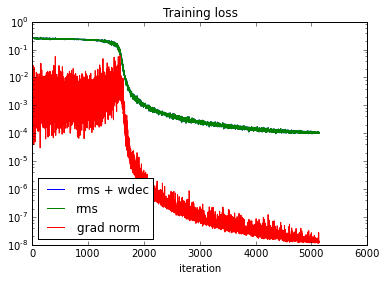

In [15]:
parity_net.initialize()

# you can tweek the learning rate. 1e-2 worked best for me
parity_trainer.lrate.set_value(1e-2)

losses = []

# when set to 1 the net recieves an error signal after each step
# when set to 0 the net recieves an error signal only once at the end
full_sup = 1

# without full_supervision it doesn't train for sequences longer than 3
seq_len = 10

# this enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
max_seq_len = 50

for i in xrange(100000):
    Xp, Yp = gen_parity_examples(seq_len, 10)
    ret = parity_trainer.train_function(Xp, Yp, full_sup)
    losses.append((i,) + tuple(ret))
    if ret[0]<1e-4:
        seq_len += 1
        if seq_len>max_seq_len:
            break
        print i, "Increasing seq length to: ", seq_len
    if i%5000 == 0:
        print i, ret
    
losses_a = np.array(losses)

semilogy(losses_a[:,0], losses_a[:,2], label='rms + wdec')
semilogy(losses_a[:,0], losses_a[:,2], label='rms')
plot(losses_a[:,0], losses_a[:,3], label='grad norm')

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

In [17]:
Xp, Yp = gen_parity_examples(500, 100)
parity_test_function(Xp, Yp, 1)

0.00010651069897

# Addition task

Here we explore the task of adding two inputs marked by a binary inicators. This is a difficult task, because the net must learn to ignore the spurious inputs and to discover the relationship between the desired output and two distant time steps.

In [18]:
# adapted from 
# https://github.com/pascanur/trainingRNNs/blob/master/addition.py
def gen_addition_example(T, batchsize):
    rng = numpy.random
    
    l = rng.randint(T, int(T * 1.1+0.9))
    p0 = rng.randint(0, int(l*.1), size=(batchsize,))
    p1 = rng.randint(0, int(l*.4), size=(batchsize,)) + int(l*.1)
    
    X = rng.uniform(size=(l, batchsize, 2)).astype('float32')
    X[:,:,0] = 0.
    X[p0, numpy.arange(batchsize), numpy.zeros((batchsize,),
                                                dtype='int32')] = 1.
    X[p1, numpy.arange(batchsize), numpy.zeros((batchsize,),
                                                dtype='int32')] = 1.

    Y = (X[p0, numpy.arange(batchsize),
           numpy.ones((batchsize,), dtype='int32')] + \
         X[p1, numpy.arange(batchsize),
           numpy.ones((batchsize,), dtype='int32')])/2.
    return X, Y.reshape((-1,1)).astype('float32')

Xa,Ya = gen_addition_example(10, 3)
print 'X:', Xa[:,0,:], '\nY:', Ya[0,:]

X: Shape: (10, 2)
[[ 1.          0.57852113]
 [ 0.          0.71686029]
 [ 0.          0.54578042]
 [ 1.          0.27510166]
 [ 0.          0.64356309]
 [ 0.          0.79832804]
 [ 0.          0.24421814]
 [ 0.          0.90099776]
 [ 0.          0.76795334]
 [ 0.          0.07127649]] 
Y: Shape: (1,)
[ 0.4268114]


In [19]:
class LSTM_RNN(RecurrentLayer):
    """
    Implementation follows Alex Graves, Abdel-rahman Mohamed and Geoffrey Hinton
    "SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS"
    http://www.cs.toronto.edu/~fritz/absps/RNN13.pdf
    """
    def __init__(self, in_dim, hidden_dim,
                 hidden_activation=TT.tanh,
                 rec_weight_init=None,
                 weight_init=None, bias_init=None, 
                 forget_bias_init=None, 
                 **kwargs):
        super(LSTM_RNN, self).__init__(**kwargs)
        rec_weight_init = default(
            rec_weight_init, IsotropicGaussian(1.0/sqrt(hidden_dim)))
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        forget_bias_init = default(
            weight_init, Constant(1.))
        self.hidden_activation = hidden_activation
        
        #
        # Gates
        #
        
        for gate in 'ifo':
            self.add_param('Wx' + gate, (in_dim, hidden_dim), 
                           weight_init)
            self.add_param('Wh' + gate, (hidden_dim, hidden_dim), 
                           weight_init)
            # Note: a cell is only connected to its own gates
            # Wc... are diagonal - so we allocate only a vector
            # for them
            self.add_param('Wc' + gate, (hidden_dim,), 
                           weight_init)
            self.add_param('B' + gate, (hidden_dim,), 
                           bias_init)
        
        #
        # Note - forget gate bias has a different initializer, because
        # we often want to initialize it to 1
        #
        self.Bf.tag.initializer = forget_bias_init
        
        # Cell
        self.add_param('Wxc', (in_dim, hidden_dim), 
                       weight_init)
        self.add_param('Whc', (hidden_dim, hidden_dim), 
                       weight_init)
        self.add_param('Bc', (hidden_dim,), 
                       bias_init)
        
        # Initial states
        self.add_param('h0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.h0)
        self.add_param('c0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.c0)
        
        
    def transition(self, x, h, c):
        """
        One step of LSTM transition.
        
        x is the previous input
        h is the previous hidden state
        c is the previous memory cell content
        """
        
        #
        # Please note:
        # The implementation below is not speed-optimal
        # usually, it pays off to group similar matrix multiplications
        # by grouping gates.
        #
        # Also, input-related computations should be moved out of scan since
        # they can be done for all steps in parallel.
        #
        
        
        s = TT.nnet.sigmoid

        # Note: for cells we do element0wise multiplication which 
        # is equvalent to a matrix multiplication with a diagonal matrix!
        i = s(x.dot(self.Wxi) + h.dot(self.Whi) + c*self.Wci + self.Bi)
        f = s(x.dot(self.Wxf) + h.dot(self.Whf) + c*self.Wcf + self.Bf)
        
        c_new = f*c + i*self.hidden_activation(x.dot(self.Wxc) + h.dot(self.Whc) + self.Bc)
        o = s(x.dot(self.Wxo) + h.dot(self.Who) + c_new*self.Wco + self.Bo)
        h_new = o * self.hidden_activation(c_new)
        
        return h_new, c_new

In [20]:
class AdditionNet(Chain):
    def __init__(self, hidden_dim, num_layers=1,
                 use_lstm=True,
                 **kwargs):
        super(AdditionNet, self).__init__(**kwargs)
        self.use_lstm = use_lstm
        self.recs = []
        
        #
        # Here we introduce a multilayer LSTM network. We simply feed the hidden states of the
        # lower layers as the inputs of the higher ones. Optionally, the inputs can also be connected
        # to the upper layers (not implemented in the code).
        #
        
        for hid in xrange(num_layers):
            if hid == 0:
                in_dim = 2
            else:
                in_dim = hidden_dim
            if use_lstm:
                rec = LSTM_RNN(in_dim=in_dim, hidden_dim=hidden_dim)
            else:
                rec = SimpleRNN(in_dim=in_dim, hidden_dim=hidden_dim)
            self.recs.append(rec)
            self.children.append(rec)
        
        self.merge = MergeInputHiddens(
            in_dim=2, hidden_dim=hidden_dim,
            out_dim=1
            )
        self.children.append(self.merge)
        
        self.X = TT.tensor3('X')
        self.Y = TT.matrix('Y')
        
        self.inputs = [self.X, self.Y]
    
    def apply(self, X):
        H = X
        for rec in self.recs:
            H = rec.apply(H)
            if self.use_lstm: # we don't use cell contents
                H = H[0]
        O = self.merge.apply(X[-1:], H[-1:])
        return O

    def get_loss(self):
        net_output = self.apply(self.X)
        return ((net_output - self.Y)**2).mean()

In [25]:
theano.config.compute_test_value='off'
theano.config.print_test_value=True
debug = False

addition_net = AdditionNet(hidden_dim=20, use_lstm=True)
addition_net.initialize()

addition_net_loss = addition_net.get_loss()

addition_test_function = theano.function(addition_net.inputs, 
                                       addition_net_loss)
Xa, Ya = gen_addition_example(10,20)
addition_test_function(Xa, Ya)

5.44661998749

In [26]:
# Use RMSProp to train the network

addition_trainer = Trainer(addition_net_loss, addition_net.parameters, addition_net.inputs)

The SimpleRNN net converges to an RMS of about 0.04 - this is roughly the RMS if we disregard one number - If we don't sume over one number, the error is simply the expected value (i.e. 0.5) divide by 2 (from the task definition) and squared, or 0.25\**2 = 0.0625.

The LSTM eventually discovers the relation and gets better, though it needs a curriculum to train.

0 [1.31879770756, 1.41429138184, 247.862625122]
500 [0.0331892333925, 0.112647615373, 1.15076601505]
1000 [0.00378292915411, 0.0660145282745, 0.00784769933671]
1500 [0.0172020792961, 0.0658032223582, 0.343105554581]
2000 [0.00656956480816, 0.0445881262422, 0.107080623507]
2500 [0.0110275791958, 0.0408838242292, 0.217169880867]
3000 [0.00182098255027, 0.0253630969673, 0.0135718910024]
3500 [0.00484537193552, 0.0235288348049, 0.077718809247]
4000 [0.0038986846339, 0.0188046712428, 0.0724524855614]
4500 [0.0068940478377, 0.0189107768238, 0.0768703967333]
5000 [0.0033547070343, 0.0131110092625, 0.039958178997]
5500 [0.00579873425886, 0.0138365961611, 0.127941668034]
6000 [0.00213885912672, 0.00885619595647, 0.033503651619]
6500 [0.00167602568399, 0.00736061763018, 0.0313998162746]
7000 [0.000561986700632, 0.00544132757932, 0.00290216365829]
7500 [0.000601124891546, 0.00482308398932, 0.00549443997443]
8000 [0.001022765995, 0.00474198907614, 0.0184184871614]
8500 [0.00298879435286, 0.0063059

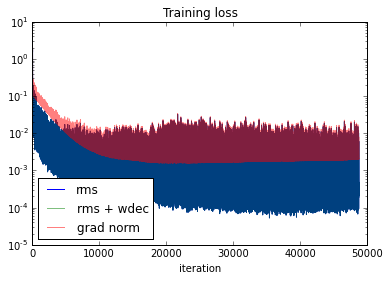

In [53]:
addition_net.initialize()

# you can tweek the learning rate. 1e-2 worked best for me
if addition_net.use_lstm:
    addition_trainer.lrate.set_value(5e-3)
else:
    addition_trainer.lrate.set_value(1e-3)
addition_trainer.max_grad_norm.set_value(10.)
# weight decay seems to be important for generalization
addition_trainer.wdec.set_value(1e-4)

losses = []

# without full_supervision it doesn't train for sequences longer than 3
seq_len = 20

# this enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
max_seq_len = 200

for i in xrange(100000):
    # note: we need to train on sequences of all lengths in order to
    # prevent forgetting the solution on short sequences
    this_len = np.random.randint(10, seq_len+1)
    Xa, Ya = gen_addition_example(this_len, 100)
    ret = addition_trainer.train_function(Xa, Ya)
    losses.append((i,) + tuple(ret))
    if this_len>seq_len*0.9 and ret[0] < 0.0002:
        seq_len += 5
        if seq_len>max_seq_len:
            break
        print i, "Increasing seq length to: ", seq_len
    if i%500 == 0:
        print i, ret
    
losses_a = np.array(losses)

semilogy(losses_a[:,0], losses_a[:,1], label='rms')
semilogy(losses_a[:,0], losses_a[:,1], alpha=0.5, label='rms + wdec')
plot(losses_a[:,0], losses_a[:,2], alpha=0.5, label='grad norm')

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

In [78]:
Xa, Ya = gen_addition_example(400,2000)
addition_test_function(Xa, Ya)

0.00158890557941

0 [0.832095503807, 0.836304485798, 236.203704834]
500 [0.526300609112, 0.530508577824, 110.485961914]
1000 [0.0267470758408, 0.0309113115072, 2.32760238647]
1500 [0.0103317759931, 0.0144850723445, 0.499453485012]
2000 [0.00848443433642, 0.0126282218844, 4.84773159027]
2500 [0.00318341841921, 0.00730416225269, 0.293113470078]
3000 [0.00485196523368, 0.00894743297249, 4.56355237961]
3500 [0.00708141550422, 0.0111521445215, 7.4047036171]
4000 [0.00144326116424, 0.00548987463117, 0.0140902921557]
4500 [0.00142763147596, 0.00545142870396, 0.00740704499185]
5000 [0.00957231968641, 0.0135708926246, 14.1857290268]
5500 [0.00770025793463, 0.011676883325, 11.3290777206]
6000 [0.00762740010396, 0.0115815093741, 10.3973913193]
6500 [0.00359190162271, 0.00752467941493, 4.54958343506]
7000 [0.00155353161972, 0.00546516804025, 0.918671071529]
7500 [0.00149022857659, 0.00538079114631, 1.11529827118]
8000 [0.008719089441, 0.012589706108, 13.113658905]
8500 [0.00198965822347, 0.00583996390924, 1.6768400

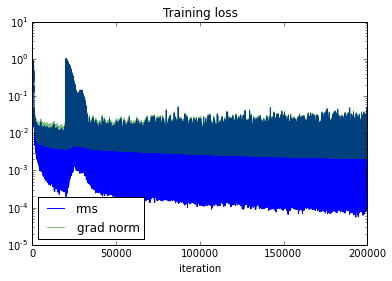

In [68]:
theano.config.compute_test_value='off'
theano.config.print_test_value=True
debug = False

addition_rnn_net = AdditionNet(hidden_dim=20, use_lstm=False)
addition_rnn_net.initialize()

addition_rnn_net_loss = addition_rnn_net.get_loss()

addition_rnn_test_function = theano.function(addition_rnn_net.inputs, 
                                             addition_rnn_net_loss)
Xa, Ya = gen_addition_example(10,20)
addition_rnn_test_function(Xa, Ya)

addition_rnn_trainer = Trainer(addition_rnn_net_loss, addition_rnn_net.parameters, addition_rnn_net.inputs)

addition_rnn_net.initialize()

# you can tweek the learning rate. 1e-2 worked best for me
addition_rnn_trainer.lrate.set_value(1e-3)
addition_rnn_trainer.max_grad_norm.set_value(.5)
addition_rnn_trainer.wdec.set_value(1e-4)

rnn_losses = []

# without full_supervision it doesn't train for sequences longer than 3
seq_len = 10

# this enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
max_seq_len = 100

for i in xrange(200000):
    this_len = np.random.randint(10, seq_len+1)
    Xa, Ya = gen_addition_example(this_len, 100)
    rnn_ret = addition_rnn_trainer.train_function(Xa, Ya)
    rnn_losses.append((i,) + tuple(rnn_ret))
    if this_len>seq_len*0.9 and rnn_ret[0] < 0.0002:
        seq_len += 5
        if seq_len>max_seq_len:
            break
        print i, "Increasing seq length to: ", seq_len
    if i%500 == 0:
        print i, rnn_ret
    
rnn_losses_a = np.array(rnn_losses)

semilogy(rnn_losses_a[:,0], rnn_losses_a[:,1], label='rms')
plot(rnn_losses_a[:,0], rnn_losses_a[:,2], alpha=0.5, label='grad norm')

legend(loc='lower left')
title('Training loss')
xlabel('iteration')

In [75]:
Xa, Ya = gen_addition_example(20,2000)
addition_rnn_test_function(Xa, Ya)

0.00430398294702